# Nucleotide and protein sequences

In [1]:
import re

import Bio.Entrez
import Bio.SeqIO
import matplotlib.pyplot as plt

Bio.Entrez.email = "your.email@example.com"

## Download Sequence from NCBI

ID: NM_000520.6
Name: NM_000520
Description: Homo sapiens hexosaminidase subunit alpha (HEXA), transcript variant 2, mRNA
Seq length: 4785 bp
First 100 seq bases: CTCACGTGGCCAGCCCCCTCCGAGAGGGGAGACCAGCGGGCCATGACAAGCTCCAGGCTTTGGTTTTCGCTGCTGCTGGCGGCAGCGTTCGCAGGACGGG ...



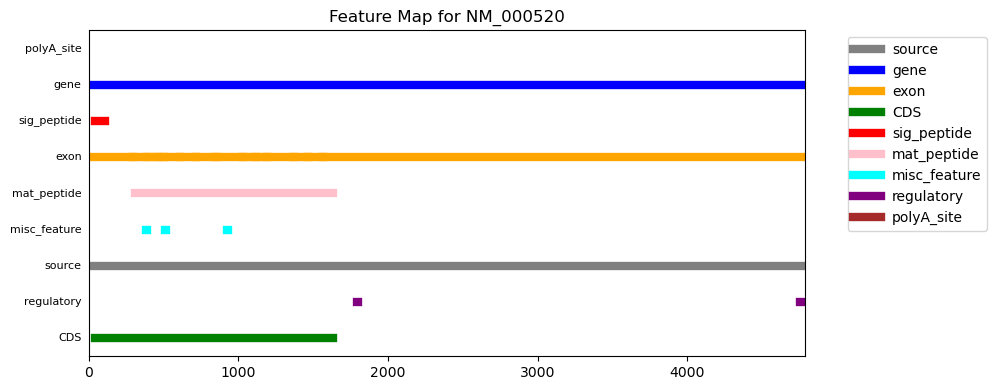

In [2]:
def getgenbank(accession: str, db: str = "nucleotide", *, verbose: bool = True) -> Bio.SeqIO.SeqRecord:
    """Equivalent to Matlab's getgenbank function.

    :param db: 'nucleotide' or 'protein'"""

    with Bio.Entrez.efetch(db=db, id=accession, rettype="gb", retmode="text") as handle:
        record = Bio.SeqIO.read(handle, "genbank")
        if verbose:
            print_info(record)
            plot_features(record)
        return record


def print_info(record: Bio.SeqIO.SeqRecord) -> None:
    print(f"ID: {record.id}")
    print(f"Name: {record.name}")
    print(f"Description: {record.description}")
    print(f"Seq length: {len(record.seq)} bp")
    print(f"First 100 seq bases: {record.seq[:100]} ...")
    print()


def plot_features(record: Bio.SeqIO.SeqRecord) -> None:
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_xlim(0, len(record.seq))
    ax.set_yticks([])
    ax.set_title(f"Feature Map for {record.name}")

    feature_colours = {
        "CDS": "green",
        "gene": "blue",
        "exon": "orange",
        "source": "grey",
        "regulatory": "purple",
        "sig_peptide": "red",
        "mat_peptide": "pink",
        "polyA_site": "brown",
        "misc_feature": "cyan",
    }
    feature_types_present = list(set(f.type for f in record.features if f.type in feature_colours))
    y_levels = {ftype: i * 2 + 1 for i, ftype in enumerate(feature_types_present)}
    ax.set_ylim(0, (len(feature_types_present) - 1) * 2 + 2 if feature_types_present else 2)

    plotted_labels = set()
    for feature in record.features:
        ftype = feature.type
        if ftype in feature_colours and ftype in y_levels:
            label = ftype if ftype not in plotted_labels else None
            ax.plot(
                [feature.location.start, feature.location.end],
                [y_levels[ftype], y_levels[ftype]],
                lw=6,
                color=feature_colours[ftype],
                label=label,
            )
            if label:
                plotted_labels.add(ftype)
                ax.text(-0.01 * len(record.seq), y_levels[ftype], ftype, ha="right", va="center", fontsize=8)

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


record = getgenbank("NM_000520")

The sequence `NM_000520` corresponds to the human `HEXA` (hexosaminidase A) gene, which encodes the alpha subunit of the beta-hexosaminidase enzyme. This enzyme is crucial in the degradation of certain molecules containing toxic N-acetyl hexosamines.

## Open Reading Frames (ORFs)

An **open reading frame (ORF)** is a continuous stretch of nucleotides in a DNA or RNA sequence that begins with a start codon (typically `ATG` in DNA or `AUG` in RNA) and ends at a stop codon (`TAA`, `TAG`, or `TGA` in DNA; `UAA`, `UAG`, or `UGA` in RNA). The ORF represents the part of the genetic sequence that can potentially be translated into a protein, as it does not contain any in-frame stop codons between the start and stop codons.

A **coding DNA sequence (CDS)** is the portion of a gene's DNA or RNA that specifically codes for a protein. It consists of a continuous stretch of codons that starts with a start codon (typically `ATG` in DNA or `AUG` in RNA) and ends with a stop codon (`TAA`, `TAG`, or `TGA` in DNA; `UAA`, `UAG`, or `UGA` in RNA). The CDS determines the exact sequence of amino acids in the resulting protein.

- Every CDS is, by definition, an ORF - it is a sequence with a start and stop codon that can be translated into a protein.
- However, not every ORF is a CDS. Many ORFs are never translated or do not correspond to real protein-coding genes.
- The CDS is the biologically validated, functional ORF that is actually used by the cell to make a protein.

DNA and RNA sequences are read in groups of three nucleotides called codons. When translating a sequence into a protein, there are three possible starting positions on a given strand to begin reading these codons. These are called **(reading) frames**:

- Frame 1: Starts reading from the 1st nucleotide.
- Frame 2: Starts reading from the 2nd nucleotide.
- Frame 3: Starts reading from the 3rd nucleotide.

There are three forward reading frames (+1, +2, +3) and three reverse reading frames (-1, -2, -3).

Frames are not the same as ORFs!

- A reading frame is one of the three possible ways to partition the sequence into codons.
- An Open Reading Frame (ORF) is a specific stretch of nucleotides within a reading frame that starts with a start codon (like `ATG`) and ends with a stop codon (`TAA`, `TAG`, or `TGA`), potentially coding for a protein.

The code searches for ORFs in each of the three reading frames because a gene's coding sequence might start in any one of them.

In [3]:
atg_positions = [m.start() for m in re.finditer("ATG", str(record.seq))]
print(f"\nFound {len(atg_positions)} ATG codons at positions: {atg_positions}")


Found 62 ATG codons at positions: [42, 187, 319, 350, 403, 406, 613, 618, 661, 679, 705, 754, 934, 942, 1006, 1056, 1138, 1150, 1242, 1321, 1416, 1429, 1531, 1594, 1668, 1801, 1825, 1858, 1933, 1977, 2076, 2086, 2162, 2452, 2658, 2683, 2792, 2831, 2841, 3021, 3025, 3093, 3134, 3173, 3255, 3384, 3667, 3688, 3733, 3815, 3954, 4005, 4262, 4317, 4413, 4447, 4503, 4531, 4557, 4576, 4657, 4666]


In [4]:
def seqshoworfs(
    seq: Bio.Seq.Seq,
    min_protein_length: int = 100,
    *,
    verbose: bool = True,
) -> list[tuple[int, int, int, int, str]]:
    """Equivalent to Matlab's seqshoworfs function.

    Returns a list of tuples: (strand, frame on that strand, start, end, amino acid seq)"""
    orfs = []
    seq_len = len(seq)

    # Search forward strand (+)
    for frame in range(3):
        # Trim sequence slice to be multiple of 3
        seq_slice = seq[frame:]
        trimmed_len = len(seq_slice) - (len(seq_slice) % 3)
        if trimmed_len == 0:
            continue  # Skip if slice is too short after trimming
        trimmed_seq_slice = seq_slice[:trimmed_len]

        translation = trimmed_seq_slice.translate(to_stop=False)  # Translate trimmed sequence
        aa_seq = str(translation)
        starts = [m.start() for m in re.finditer("M", aa_seq)]  # Find all Methionine (start) codons
        stops = [m.start() for m in re.finditer("\\*", aa_seq)]  # Find all stop codons (*)

        for start_aa in starts:
            # Find the first stop codon *after* this start codon
            stop_aa = next((s for s in stops if s > start_aa), None)
            if stop_aa:
                orf_len_aa = stop_aa - start_aa  # Length in amino acids
                if orf_len_aa >= min_protein_length:
                    # Convert AA positions back to DNA positions on the forward strand
                    start_dna = start_aa * 3 + frame
                    end_dna = (stop_aa + 1) * 3 + frame  # End position is *after* the stop codon
                    orfs.append((+1, frame + 1, start_dna, end_dna, aa_seq[start_aa:stop_aa]))

    # Search reverse complement strand (-)
    rc_seq = seq.reverse_complement()
    for frame in range(3):
        # Trim reverse complement slice to be multiple of 3
        rc_seq_slice = rc_seq[frame:]
        trimmed_len = len(rc_seq_slice) - (len(rc_seq_slice) % 3)
        if trimmed_len == 0:
            continue  # Skip if slice is too short after trimming
        trimmed_rc_seq_slice = rc_seq_slice[:trimmed_len]

        translation = trimmed_rc_seq_slice.translate(to_stop=False)  # Translate trimmed sequence
        aa_seq = str(translation)
        starts = [m.start() for m in re.finditer("M", aa_seq)]
        stops = [m.start() for m in re.finditer("\\*", aa_seq)]

        for start_aa in starts:
            stop_aa = next((s for s in stops if s > start_aa), None)
            if stop_aa:
                orf_len_aa = stop_aa - start_aa
                if orf_len_aa >= min_protein_length:
                    # Convert AA positions on reverse complement back to DNA positions on the *original* forward strand
                    # Start on rc maps to end on fwd, End on rc maps to start on fwd
                    start_dna_rc = start_aa * 3 + frame
                    end_dna_rc = (stop_aa + 1) * 3 + frame
                    # Map back to forward strand coordinates
                    start_dna_orig = seq_len - end_dna_rc
                    end_dna_orig = seq_len - start_dna_rc
                    orfs.append((-1, frame + 1, start_dna_orig, end_dna_orig, aa_seq[start_aa:stop_aa]))

    # Optional: Sort ORFs by their start position on the forward strand
    orfs.sort(key=lambda x: x[2])

    if verbose:
        print(f"\nFound {len(orfs)} ORFs (longer than 100 aa) on both strands:")
        for i, (strand, frame, start, end, aa) in enumerate(orfs):
            strand_char = "+" if strand == 1 else "-"
            print(
                f" ORF {i+1}: Strand {strand_char}, Frame {frame}, Pos {start}-{end} (len {end-start} bp), {len(aa)} aa"
            )

    return orfs


orfs = seqshoworfs(record.seq)


Found 7 ORFs (longer than 100 aa) on both strands:
 ORF 1: Strand +, Frame 1, Pos 42-1632 (len 1590 bp), 529 aa
 ORF 2: Strand +, Frame 1, Pos 618-1632 (len 1014 bp), 337 aa
 ORF 3: Strand +, Frame 1, Pos 705-1632 (len 927 bp), 308 aa
 ORF 4: Strand +, Frame 1, Pos 942-1632 (len 690 bp), 229 aa
 ORF 5: Strand +, Frame 1, Pos 1056-1632 (len 576 bp), 191 aa
 ORF 6: Strand +, Frame 1, Pos 1242-1632 (len 390 bp), 129 aa
 ORF 7: Strand +, Frame 1, Pos 1668-1974 (len 306 bp), 101 aa


In [5]:
def find_gene_in_frames(record: Bio.SeqIO.SeqRecord) -> None:
    cds_translation = get_cds_translation(record)

    # Search forward strand (+)
    for frame in range(3):
        # Trim sequence slice to be multiple of 3
        seq_slice = record.seq[frame:]
        trimmed_len = len(seq_slice) - (len(seq_slice) % 3)
        if trimmed_len == 0:
            continue  # Skip if slice is too short after trimming
        trimmed_seq_slice = seq_slice[:trimmed_len]

        translated = trimmed_seq_slice.translate(to_stop=False)  # Translate trimmed sequence

        print(f"\nTranslation in frame +{frame + 1}: {translated}")
        if cds_translation in str(translated):
            print("Translation matches the annotated CDS translation.")


def get_cds_translation(record: Bio.SeqIO.SeqRecord, *, verbose: bool = True) -> str:
    if verbose:
        print("\nAnnotated CDS regions:")
    for feature in record.features:
        if feature.type == "CDS":
            location = feature.location
            protein_id = feature.qualifiers.get("protein_id", ["N/A"])[0]
            translation = feature.qualifiers.get("translation", ["N/A"])[0]
            if verbose:
                print(f" - Location: {location}")
                print(f"   Protein ID: {protein_id}")
                print(f"   Translation: {translation}")
    return translation


find_gene_in_frames(record)


Annotated CDS regions:
 - Location: [42:1632](+)
   Protein ID: NP_000511.2
   Translation: MTSSRLWFSLLLAAAFAGRATALWPWPQNFQTSDQRYVLYPNNFQFQYDVSSAAQPGCSVLDEAFQRYRDLLFGSGSWPRPYLTGKRHTLEKNVLVVSVVTPGCNQLPTLESVENYTLTINDDQCLLLSETVWGALRGLETFSQLVWKSAEGTFFINKTEIEDFPRFPHRGLLLDTSRHYLPLSSILDTLDVMAYNKLNVFHWHLVDDPSFPYESFTFPELMRKGSYNPVTHIYTAQDVKEVIEYARLRGIRVLAEFDTPGHTLSWGPGIPGLLTPCYSGSEPSGTFGPVNPSLNNTYEFMSTFFLEVSSVFPDFYLHLGGDEVDFTCWKSNPEIQDFMRKKGFGEDFKQLESFYIQTLLDIVSSYGKGYVVWQEVFDNKVKIQPDTIIQVWREDIPVNYMKELELVTKAGFRALLSAPWYLNRISYGPDWKDFYIVEPLAFEGTPEQKALVIGGEACMWGEYVDNTNLVPRLWPRAGAVAERLWSNKLTSDLTFAYERLSHFRCELLRRGVQAQPLNVGFCEQEFEQT

Translation in frame +1: LTWPAPSERGDQRAMTSSRLWFSLLLAAAFAGRATALWPWPQNFQTSDQRYVLYPNNFQFQYDVSSAAQPGCSVLDEAFQRYRDLLFGSGSWPRPYLTGKRHTLEKNVLVVSVVTPGCNQLPTLESVENYTLTINDDQCLLLSETVWGALRGLETFSQLVWKSAEGTFFINKTEIEDFPRFPHRGLLLDTSRHYLPLSSILDTLDVMAYNKLNVFHWHLVDDPSFPYESFTFPELMRKGSYNPVTHIYTAQDVKEVIEYARLRGIRVLAEFDTPGHTLSWGPGIPGLLTPCYSGSEPSGTFGPVNPSLNNTYEFMSTFFLEVSSVFPDFYLHLGGDEVDFTCWKSNPEIQD

**In which reading frame is the HEXA gene located?**

Frame +1.

## Translation

In [6]:
def nt2aa(seq: Bio.Seq.Seq | Bio.Seq.MutableSeq) -> str:
    """Convert nucleotide sequence to amino acid sequence. Equivalent to Matlab's nt2aa function."""
    return str(seq.translate(to_stop=True))


record = getgenbank("NM_000685", verbose=False)
nt2aa(record.seq[356:1436]) == get_cds_translation(record, verbose=True)


Annotated CDS regions:
 - Location: [356:1436](+)
   Protein ID: NP_000676.1
   Translation: MILNSSTEDGIKRIQDDCPKAGRHNYIFVMIPTLYSIIFVVGIFGNSLVVIVIYFYMKLKTVASVFLLNLALADLCFLLTLPLWAVYTAMEYRWPFGNYLCKIASASVSFNLYASVFLLTCLSIDRYLAIVHPMKSRLRRTMLVAKVTCIIIWLLAGLASLPAIIHRNVFFIENTNITVCAFHYESQNSTLPIGLGLTKNILGFLFPFLIILTSYTLIWKALKKAYEIQKNKPRNDDIFKIIMAIVLFFFFSWIPHQIFTFLDVLIQLGIIRDCRIADIVDTAMPITICIAYFNNCLNPLFYGFLGKKFKRYFLQLLKYIPPKAKSHSNLSTKMSTLSYRPSDNVSSSTKKPAPCFEVE


True

**Does translating the sequence for the CDS feature.location indices correspond to the CDS feature.translation**?

Yes.